In [1]:
%reset
# !module load texlive
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import matplotlib
%matplotlib inline

import pickle as pk
import numpy as np
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
import torch

dev = torch.device("cuda")
# torch.cuda.set_device(dev)
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.distributions import Normal
# change the root directory for this notebook

root_dir = '/mnt/home/spandey/ceph/AR_NPE/'
os.chdir(root_dir)
import colossus
import sys, os
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
from tqdm import tqdm
%load_ext autoreload
%autoreload 2




In [2]:
# # check if GPU is available
print(torch.cuda.is_available())
# # test how many cuda devices are available
# print(torch.cuda.device_count())
# # print names of the cuda devices available
# for i in range(torch.cuda.device_count()):
#     print(torch.cuda.get_device_name(i))





True


In [229]:
import colossus
# set cosmology
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
Mmin=13.1
Mmax=16.0
lgM_array = np.linspace(Mmin, Mmax, 1000)
M_array = 10**lgM_array
hmf_tinker = mass_function.massFunction(M_array, 0, mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
# hmf_sheth99 = mass_function.massFunction(M_array, 0, mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
hmf_bh11 = mass_function.massFunction(M_array, 0, mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')



In [230]:
lgM_rescaled = (lgM_array - Mmin)/(Mmax-Mmin) -0.5



In [231]:
import scipy as sp
int_val = sp.integrate.simps(hmf_tinker, lgM_rescaled)
hmf_tinker_pdf = hmf_tinker/int_val

int_val = sp.integrate.simps(hmf_bh11, lgM_rescaled)
hmf_bh11_pdf = hmf_bh11/int_val


In [232]:
# define the cdf of the halo mass function
hmf_bh11_cdf = np.zeros_like(hmf_bh11_pdf)
for i in range(len(hmf_bh11_cdf)):
    hmf_bh11_cdf[i] = sp.integrate.simps(hmf_bh11_pdf[:i+1], lgM_rescaled[:i+1])

    


In [233]:
# # sample from the cdf
# n_samples = 100000
# u = np.random.uniform(0, 1, n_samples)
# lgM_samples = np.zeros_like(u)
# for i in range(len(u)):
#     lgM_samples[i] = lgM_rescaled[np.argmin(np.abs(hmf_cdf - u[i]))]


In [234]:
# do the sampling by defining an inverse interpolation between cdf and lgM_rescaled
n_samples = 1000000
import numpy as np
from scipy.interpolate import interp1d
u = np.random.uniform(0, 1, n_samples)
lgM_interp = interp1d(np.log(hmf_bh11_cdf[1:]), lgM_rescaled[1:], kind='linear', fill_value='extrapolate')
# lgM_samples2 = lgM_interp(np.log(u))


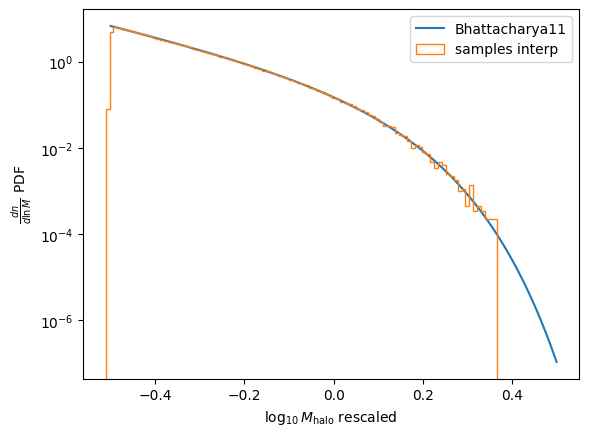

In [235]:
lgM_samples2 = lgM_interp(np.log(u))
pl.figure()
pl.plot(lgM_rescaled, (hmf_bh11_pdf), label='Bhattacharya11')
# _ = pl.hist(lgM_samples, bins=100, density=True, label='samples')
_ = pl.hist(lgM_samples2, bins=100, density=True, label='samples interp', histtype='step')
pl.xlabel(r'$\log_{10} M_{\rm halo}$ rescaled')
pl.ylabel(r'$\frac{dn}{d\ln M}$ PDF')
pl.legend()
pl.yscale('log')



In [236]:
torch.Tensor(np.array([lgM_rescaled])).shape
# self.hmf_pdf_tointerp = torch.Tensor([hmf_pdf_tointerp])
# self.hmf_cdf_tointerp = torch.Tensor([hmf_cdf_tointerp])


torch.Size([1, 1000])

In [237]:
ji = 0
# ns_d = 128
ns_d = 256
# ns_d = 512
nb = 8
nax_d = ns_d // nb
nf = 3
layers_types = ['res', 'res', 'res', 'res']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

# z=127 is the initial condition
z_all = [0, 127, 'z_0_diff_sig_1', 'z_0_diff_sig_3']
# z_all = [0]
# ns_h = 128
ns_h = 256
nax_h = ns_h // nb

nsims_per_batch = 64
# nbatches_train = nb**3//nsims_per_batch
nbatches_train = 8






In [238]:
hidden_dim_MAF = 5
learning_rate = 0.01
K_M1 = 5
B_M1 = 0.5
nflows_M1_NSF = 5

K_Mdiff = 5
B_Mdiff = 3
nflows_Mdiff_NSF = 3

# base_dist_M1 = 'gumbel'
# base_dist_M1 = 'gauss'
base_dist_M1 = 'physical_hmf'
base_dist_Mdiff = 'gumbel'
ngauss_M1 = 5

changelr = False
ksize = nf
nfeature_cnn = 4
nout_cnn = 4 * nfeature_cnn
ninp = len(z_all)
num_cond = nout_cnn + ninp



In [239]:
# Load the density data
df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train = load_density_halo_data_NGP(
    ji, ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    )

# # Prepare the density and halo data
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, nsims=nsims_per_batch,
    nbatches = nbatches_train
    )




0 64
64 128
128 192
192 256
256 320
320 384
384 448
448 512


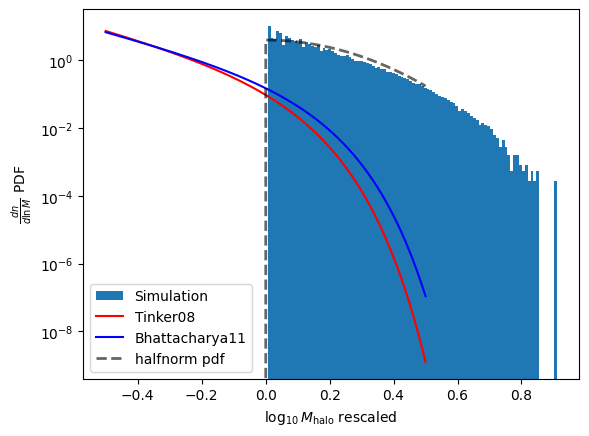

In [240]:
all_Mh = df_Mh_all_train.flatten()
# select the ones that are non-zero
all_Mh = all_Mh[all_Mh > 0]
all_Mh_rescaled = (all_Mh - Mmin)/(Mmax-Mmin)
# write a half gaussian distribution for the halo mass
from scipy.stats import halfnorm
pl.figure()
_ = pl.hist(all_Mh_rescaled, bins=100, density=True, label='Simulation')
# pl.plot(lgM_rescaled, (hmf_pdf), label='Sheth99')
pl.plot(lgM_rescaled, (hmf_tinker_pdf), color='r', label='Tinker08')
pl.plot(lgM_rescaled, (hmf_bh11_pdf), color='b', label='Bhattacharya11')
pl.plot(lgM_rescaled, halfnorm.pdf(lgM_rescaled, 0.0, 0.2),
       'k--', lw=2, alpha=0.6, label='halfnorm pdf')
pl.xlabel(r'$\log_{10} M_{\rm halo}$ rescaled')
pl.ylabel(r'$\frac{dn}{d\ln M}$ PDF')
pl.yscale('log')
pl.legend()






In [298]:
# df_d_all_nsh_train.shape, df_Mh_all_train.shape
delta_DM_0 = np.exp(df_d_all_nsh_train[:,0,...]) - 1
# np.amin(delta_DM_0), np.amax(delta_DM_0)
# delta_min, delta_max = -1.0, 200.0
# delta_min, delta_max = 10.0, 50.0
delta_min, delta_max = 5.0, 10.0
indsel_delta = np.where((delta_DM_0 >= delta_min) & (delta_DM_0 <= delta_max))





In [299]:
# df_d_all_nsh_train[:,3,...]

In [300]:
# np.amin(delta_DM_0), np.amax(delta_DM_0)
# df_d_all_nsh_train
# np.exp(df_d_all_nsh_train[:,0,...]) - 1

# df_d_all_nsh_train[:,0,...]


In [301]:
df_Mh_all_train_sel = df_Mh_all_train[indsel_delta[0],indsel_delta[1],indsel_delta[2],indsel_delta[3],:]
# indsel_delta[1].shape

# df_Mh_all_train[0,0,:,:]

df_Mh_all_train_flatten = df_Mh_all_train_sel.flatten()
all_halo_masses = df_Mh_all_train_flatten[df_Mh_all_train_flatten !=0] 
Mmin = 13.1
Mmax = 16.0
all_halo_masses = -0.5 + (all_halo_masses - Mmin)/(Mmax - Mmin)



In [302]:
np.amin(all_halo_masses), np.amax(all_halo_masses)


(-0.4936878598969557, 0.006663618416621775)

In [303]:
model_M_all = NSF_M_all_uncond(
    K=K_M1,
    B=B_M1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    ngauss=ngauss_M1,
    # mu_pos=False
    mu_pos=True,
    lgM_rs_tointerp=lgM_rescaled,
    hmf_pdf_tointerp=hmf_bh11_pdf,
    hmf_cdf_tointerp=hmf_bh11_cdf    
    )

model_M_all.to(dev)
print()


In [304]:
# hmf_bh11_cdf
# lgM_rescaled

In [305]:
optimizer = optim.Adam(model_M_all.parameters(), lr=learning_rate)
loss_all_it = []
loss_min = 1e20





In [306]:
X_M_all = torch.Tensor(np.array(all_halo_masses)).cuda(dev)



In [307]:
save_bestfit_model_name = 'FINAL_FINAL_COMBINED/TEST_FINALS_M_all_UNCOND_nsf5_mixgaussplexp_BATCHED_model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + \
                str(nf) + '_nsh' + str(ns_h) + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train)
# save_bestfit_model_name = 'FINAL_FINAL_COMBINED/TEST_FINALS_M_all_UNCOND_nsf5_BATCHED_model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + \
#                 str(nf) + '_nsh' + str(ns_h) + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train)

# bestfit_model = (torch.load(save_bestfit_model_name))
# model_M_all.load_state_dict(bestfit_model['state_dict'])
# optimizer.load_state_dict(bestfit_model['optimizer'])



In [325]:
ninit = 0
niterations = 2000

# torch.autograd.set_detect_anomaly(False)
for ito in tqdm(range(niterations)):
    optimizer.zero_grad()
    for g in optimizer.param_groups:
        # g['lr'] = 0.00025
        g['lr'] = 0.001

    it = ito + ninit
    logP_M_all, logdet_M_all, x_transf = model_M_all(X_M_all)
    loss = torch.mean(-logP_M_all - logdet_M_all)

    loss.backward()
    optimizer.step()

    if (np.mod(it, int(niterations / 20)) == 0) or (it == niterations - 1):
        if float(loss.cpu().detach().numpy()) < loss_min:
            loss_min = float(loss.cpu().detach().numpy())
            # print(loss1.detach().numpy(), loss2.detach().numpy(), loss3.detach().numpy())
            print('saving bf at:', ', with loss:', np.round(loss_min, 4))
            # print('saving bf at:', it, ', with loss:', np.round(loss_min, 9))
            state = {'loss_min': loss_min, 'state_dict': model_M_all.state_dict(), 'optimizer': optimizer.state_dict()}

            torch.save(
                state, save_bestfit_model_name
                )


            

  5%|▌         | 104/2000 [00:03<00:57, 33.05it/s]

saving bf at: , with loss: -1.0756


 10%|█         | 204/2000 [00:06<00:54, 32.80it/s]

saving bf at: , with loss: -1.0756


 15%|█▌        | 304/2000 [00:09<00:51, 32.73it/s]

saving bf at: , with loss: -1.0756


 20%|██        | 404/2000 [00:12<00:48, 32.92it/s]

saving bf at: , with loss: -1.0756


 25%|██▌       | 504/2000 [00:15<00:45, 32.80it/s]

saving bf at: , with loss: -1.0757


 30%|███       | 604/2000 [00:18<00:42, 32.87it/s]

saving bf at: , with loss: -1.0757


 35%|███▌      | 704/2000 [00:21<00:39, 32.55it/s]

saving bf at: , with loss: -1.0757


 40%|████      | 804/2000 [00:24<00:36, 32.74it/s]

saving bf at: , with loss: -1.0757


 45%|████▌     | 904/2000 [00:27<00:33, 32.67it/s]

saving bf at: , with loss: -1.0757


 50%|█████     | 1004/2000 [00:30<00:30, 32.90it/s]

saving bf at: , with loss: -1.0757


 55%|█████▌    | 1104/2000 [00:33<00:27, 32.78it/s]

saving bf at: , with loss: -1.0757


 60%|██████    | 1204/2000 [00:36<00:24, 32.83it/s]

saving bf at: , with loss: -1.0757


 65%|██████▌   | 1304/2000 [00:39<00:21, 33.00it/s]

saving bf at: , with loss: -1.0757


 70%|███████   | 1404/2000 [00:42<00:18, 32.98it/s]

saving bf at: , with loss: -1.0757


 75%|███████▌  | 1504/2000 [00:45<00:15, 32.90it/s]

saving bf at: , with loss: -1.0757


 80%|████████  | 1604/2000 [00:48<00:12, 32.56it/s]

saving bf at: , with loss: -1.0758


 85%|████████▌ | 1704/2000 [00:51<00:09, 32.85it/s]

saving bf at: , with loss: -1.0758


 90%|█████████ | 1804/2000 [00:54<00:05, 32.96it/s]

saving bf at: , with loss: -1.0758


 95%|█████████▌| 1904/2000 [00:57<00:02, 33.04it/s]

saving bf at: , with loss: -1.0758


100%|██████████| 2000/2000 [01:00<00:00, 33.25it/s]

saving bf at: , with loss: -1.0758


In [326]:
logP_M_all


tensor([-0.4065,  0.9745,  1.1191,  ...,  1.3933,  1.3774,  1.2343],
       device='cuda:0', grad_fn=<AsStridedBackward0>)

In [327]:
# torch.Tensor(np.array([hmf_bh11_pdf])).to('cuda')
# np.log(hmf_bh11_pdf)



In [328]:
# cond_tensor.shape
# train_M1
# cond_tensor_nsh.shape
x_samp = model_M_all.sample(len(all_halo_masses)).cpu().detach().numpy()



In [329]:
# len(x_samp), len(all_halo_masses)

In [330]:
# x_samp
x_transf_np = x_transf.cpu().detach().numpy()


Text(0, 0.5, 'Histogram')

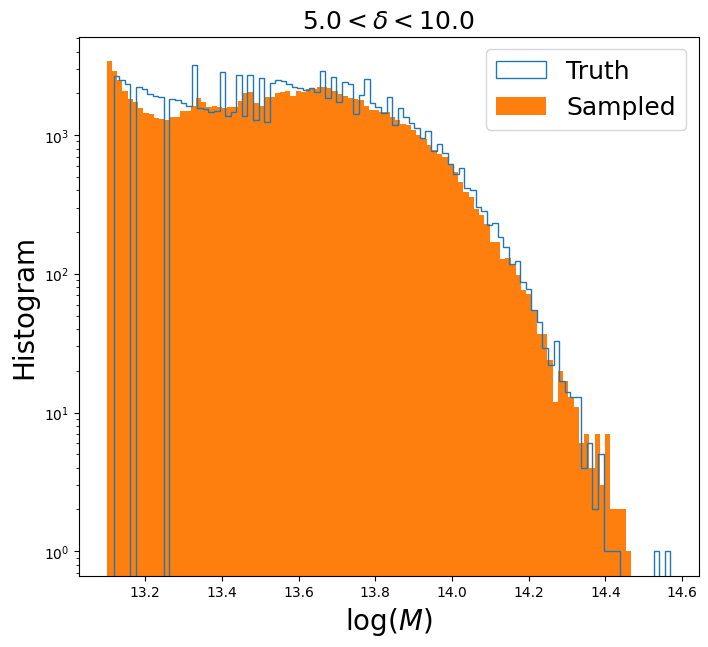

In [331]:
# x_samp.shape
pl.figure(figsize=(8,7))
# _ = pl.hist((x_samp)*(Mmax-Mmin) + Mmin, range=(Mmin,Mmax), bins=100, label='Sampled')
# _ = pl.hist((x_transf_np)*(Mmax-Mmin) + Mmin, range=(Mmin,Mmax), bins=100, label='Transformed')
# _ = pl.hist((all_halo_masses + 0.5 )*(Mmax - Mmin) + Mmin, histtype='step', density=True, range=(Mmin,Mmax), bins=100, label='Truth')
# _ = pl.hist((x_samp + 0.5)*(Mmax-Mmin) + Mmin, bins=100, density=True, label='Sampled')
_ = pl.hist((all_halo_masses + 0.5 )*(Mmax - Mmin) + Mmin, histtype='step', bins=100, label='Truth')
_ = pl.hist((x_samp + 0.5)*(Mmax-Mmin) + Mmin, bins=100, label='Sampled')


# pl.xscale('log')
pl.legend(fontsize=18)
pl.title(str(delta_min) + r'$ < \delta <$' + str(delta_max), fontsize=18)
pl.yscale('log')
pl.xlabel(r'$\log(M)$', fontsize=20)
pl.ylabel(r'Histogram', fontsize=20)


In [75]:
def interpolate(x: torch.Tensor, xp: torch.Tensor, fp: torch.Tensor) -> torch.Tensor:
    """One-dimensional linear interpolation for monotonically increasing sample
    points.

    Returns the one-dimensional piecewise linear interpolant to a function with
    given discrete data points :math:`(xp, fp)`, evaluated at :math:`x`.

    Args:
        x: the :math:`x`-coordinates at which to evaluate the interpolated
            values.
        xp: the :math:`x`-coordinates of the data points, must be increasing.
        fp: the :math:`y`-coordinates of the data points, same length as `xp`.

    Returns:
        the interpolated values, same size as `x`.
    """
    m = (fp[:,1:] - fp[:,:-1]) / (xp[:,1:] - xp[:,:-1])  #slope
    b = fp[:, :-1] - (m.mul(xp[:, :-1]) )

    indicies = torch.sum(torch.ge(x[:, :, None], xp[:, None, :]), -1) - 1  #torch.ge:  x[i] >= xp[i] ? true: false
    indicies = torch.clamp(indicies, 0, m.shape[-1] - 1)

    line_idx = torch.linspace(0, indicies.shape[0], 1, device=indicies.device).to(torch.long)
    line_idx = line_idx.expand(indicies.shape)
    # idx = torch.cat([line_idx, indicies] , 0)
    return m[line_idx, indicies].mul(x) + b[line_idx, indicies]

    

In [76]:
lgM_rs_tointerp = torch.Tensor(np.array([lgM_rescaled])).to('cuda')
hmf_pdf_tointerp = torch.Tensor(np.log(np.array([hmf_bh11_pdf]))).to('cuda')
hmf_cdf_tointerp = torch.Tensor(np.array([hmf_bh11_cdf])).to('cuda')




In [77]:
logp_transf = (interpolate(x_transf[None,:], lgM_rs_tointerp, hmf_pdf_tointerp)[0,:])



In [78]:
logp_orig = (interpolate(X_M_all[None,:], lgM_rs_tointerp, hmf_pdf_tointerp)[0,:])


In [79]:
logp_orig

tensor([1.7869, 0.0026, 1.4026,  ..., 1.0377, 1.1690, 1.4625], device='cuda:0')

In [80]:
logp_transf

tensor([1.3231, 0.6317, 1.2873,  ..., 1.2341, 1.2562, 1.2939], device='cuda:0',
       grad_fn=<SliceBackward0>)

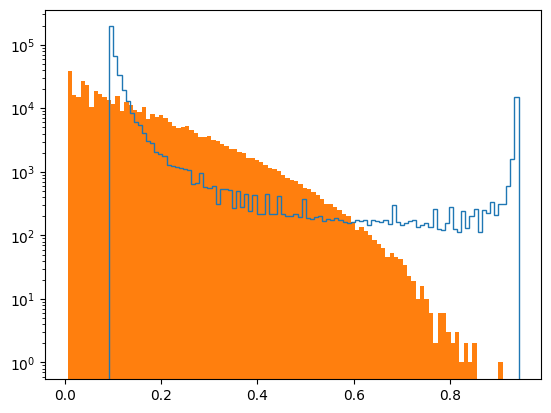

In [81]:
# X_M_all
# torch.max(logp_orig), torch.min(logp_orig)
pl.figure()
_ = pl.hist(x_transf.cpu().detach().numpy(), bins=100, label='Transformed', histtype='step')
_ = pl.hist(X_M_all.cpu().detach().numpy(), bins=100, label='Original')
pl.yscale('log')


In [40]:
# torch.max(logp_transf), torch.min(logp_transf)


(tensor(20.3338, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-6.4338, device='cuda:0', grad_fn=<MinBackward1>))

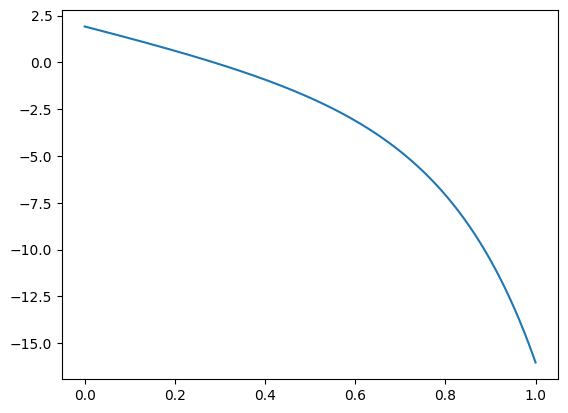

In [35]:
# hmf_pdf_tointerp
pl.figure()
pl.plot(lgM_rescaled, np.log(hmf_bh11_pdf), label='BH11')


In [ ]:
ntot = len(all_halo_masses)
u = torch.rand(ntot)
u = u.to('cuda')
# import pdb; pdb.set_trace()
# x = interpolate(torch.log(u)[None,:], torch.log(self.hmf_cdf_tointerp[:,1:]), self.lgM_rs_tointerp[:,1:])[0,:]
x = interpolate((u)[None,:], (hmf_cdf_tointerp[:,1:]), lgM_rs_tointerp[:,1:])[0,:]


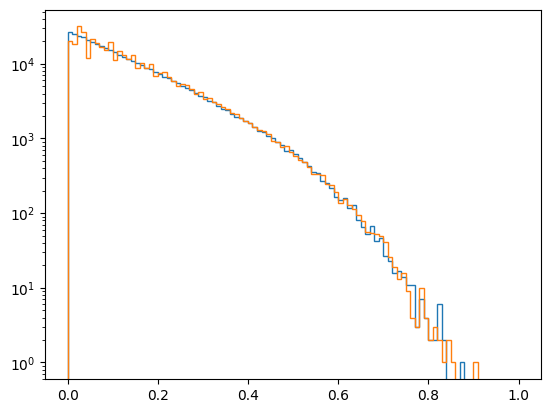

In [57]:
# x
pl.figure()
_ = pl.hist(x.cpu().detach().numpy(), bins=100, range=(0,1), histtype='step', label='Interpolated')
_ = pl.hist((all_halo_masses ), histtype='step', range=(0,1), bins=100, label='Truth')
pl.yscale('log')


In [54]:
all_halo_masses

array([0.02058536, 0.2854707 , 0.08130646, ..., 0.13741934, 0.1174221 ,
       0.07194368])